# iPRules

# Statics

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.utils import Bunch
from sklearn.datasets._base import load_csv_data
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


## Load Dataset

In [2]:
# Load Dataset
#iris
#dataset = load_iris()
target_value_name = 'class'

# Mushrooms
filename = 'mushrooms'
target_true = 'p'
target_false = 'e'
test_size = 0.33


data_file_name = f'../../data/{filename}.csv'
pandas_dataset = pd.read_csv(data_file_name)

pandas_dataset.columns = [sub.replace('%', '') for sub in pandas_dataset.columns]
target_value_name = pandas_dataset.columns[-1]

pandas_dataset[target_value_name] = pandas_dataset[target_value_name].map({target_false:0,target_true:1})

pandas_dataset.columns = [sub.replace('-', '_').replace(' ', '').replace('class', 'target_value') for sub in pandas_dataset.columns]
target_value_name = pandas_dataset.columns[-1]
feature_names = pandas_dataset.columns[0:-1]


#dataset.feature_names = [sub.replace(' ', '').replace('(cm)', '') for sub in dataset.feature_names]

pandas_dataset.head()

,cap_shape,cap_surface,cap_color,bruises3F,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,...,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat,target_value
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,1
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,0
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,0
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,1
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,0


# One Hot Encoding

In [3]:
enc = OneHotEncoder(sparse_output=False)
encoded_array = enc.fit_transform(pandas_dataset.loc[:,feature_names])
encoded_feature_names = enc.get_feature_names_out()
df_encoded = pd.DataFrame(encoded_array,columns=encoded_feature_names)
encoded_pandas_dataset = pd.concat([df_encoded, pandas_dataset],axis=1)
encoded_pandas_dataset.drop(labels= feature_names,axis=1,inplace=True)
encoded_pandas_dataset.head()

,cap_shape_b,cap_shape_c,cap_shape_f,cap_shape_k,cap_shape_s,cap_shape_x,cap_surface_f,cap_surface_g,cap_surface_s,cap_surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,target_value
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
#print(pandas_dataset.shape)

# One hot encoding + not doing anything in the rest
#ct = make_column_transformer(
#    (OneHotEncoder(), feature_names),
#    n_jobs=3,
#    remainder='passthrough',
#    sparse_threshold=0)

#pandas_dataset_encoded = ct.fit_transform(pandas_dataset).T

#print(pandas_dataset_encoded[0])

#column_names = (ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
#               + [target_value_name])

#encoded_dataset = pd.DataFrame(pandas_dataset_encoded, column_names)

#encoded_dataset.head()

In [5]:
X = encoded_pandas_dataset[encoded_feature_names]
y = encoded_pandas_dataset[target_value_name]

encoded_dataset = Bunch(
        data=X.to_numpy(),
        target=y.to_numpy(),
        target_names=target_value_name,
        feature_names=X.columns
)

#X_display = pandas_dataset.drop([target_value_name], axis=1)
#y_display = pandas_dataset[target_value_name]

#encoded_pandas_dataset = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']], columns= dataset['feature_names'] + ['target'])
#encoded_pandas_dataset.head()


# Understand Dataset

/var/folders/m3/06npm5752654l0l9zry_3b0h0000gn/T/ipykernel_19902/853910098.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


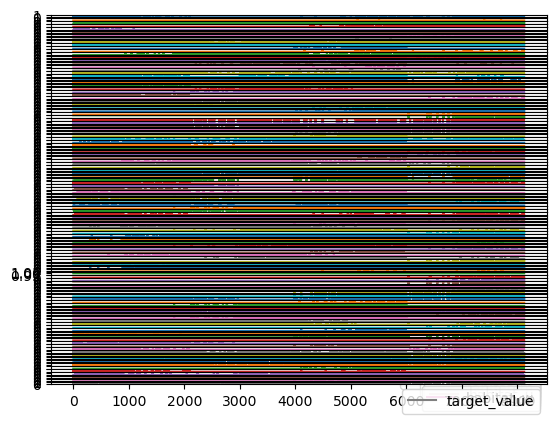

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

encoded_pandas_dataset.plot(subplots=True)

plt.tight_layout()
plt.show()

# Divide dataset

In [7]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(encoded_dataset.data, encoded_dataset.target, test_size=test_size, random_state=1)
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= encoded_dataset['feature_names'] + ['target'])
print('Sizes (without target):')
print(f'Original size {encoded_dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')

Sizes (without target):
Original size (8124, 117)
Train size (5443, 117)
Test size (2681, 117)


## Define Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100)

## iPRules

In [9]:
from iPRules.iPRules import iPRules

# initialize
tree = iPRules(
                base_ensemble=ensemble,
                feature_names=encoded_dataset.feature_names,
                target_value_name = encoded_dataset.target_names,
                chi_square_probability = 0.95,
                scale_feature_coefficient = 0.85
            )

# Fit model
tree.fit(encoded_pandas_dataset, X_train, y_train)

Fit Ensemble Model
Extract feature importance list
Generate new tree based on list


iPRules(base_ensemble=RandomForestClassifier(),
        feature_names=Index(['cap_shape_b', 'cap_shape_c', 'cap_shape_f', 'cap_shape_k',
       'cap_shape_s', 'cap_shape_x', 'cap_surface_f', 'cap_surface_g',
       'cap_surface_s', 'cap_surface_y',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=117),
        target_value_name='target_value')

# Print Model

In [10]:
print(tree)

> ------------------------------
> iPRules:
> ------------------------------
Regla 0: odor_n == 1.0 & odor_f == 0.0 & gill_size_n == 1.0 & gill_size_b == 0.0 & stalk_surface_above_ring_k == 0.0 & bruises3F_t
Regla 1: odor_n == 0.0 & odor_f == 0.0 & gill_size_n == 1.0 & gill_size_b == 0.0 & stalk_surface_above_ring_k == 0.0 & bruises3F_t == 1.0 & spore_print_color_h == 0.0 & ring_type_p == 1.0 & stalk_surface_below_ring_k == 0.0 & population_v
Regla 2: odor_n == 1.0 & odor_f == 0.0 & gill_size_n == 0.0 & gill_size_b == 1.0 & stalk_surface_above_ring_k == 0.0 & bruises3F_t == 1.0 & spore_print_color_h == 0.0 & ring_type_p == 1.0 & stalk_surface_below_ring_k == 0.0 & population_v
Regla 3: odor_n == 1.0 & odor_f == 0.0 & gill_size_n
Regla 4: odor_n == 1.0 & odor_f == 0.0 & gill_size_n == 1.0 & gill_size_b == 0.0 & stalk_surface_above_ring_k
Regla 5: odor_n
Regla 6: odor_n == 1.0 & odor_f == 0.0 & gill_size_n == 1.0 & gill_size_b == 0.0 & stalk_surface_above_ring_k == 0.0 & bruises3F_t == 0

# Predict

In [ ]:
#Divide las combinaciones en si el patrón lo muestran en supervivencia o fallecimiento.
casualties_categorized_rules, survivors_categorized_rules = tree.categorize_patterns(encoded_test_pandas_dataset, 0.9)
#Returns death and survival patterns where there's a % of the total cases of that specific type.

In [11]:
tree_preds = tree.predict(X_test)
print('The accuracy of the Tree model is :\t',metrics.accuracy_score(tree_preds,y_test))

NotFittedError: This iPRules instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# SHAP explainer

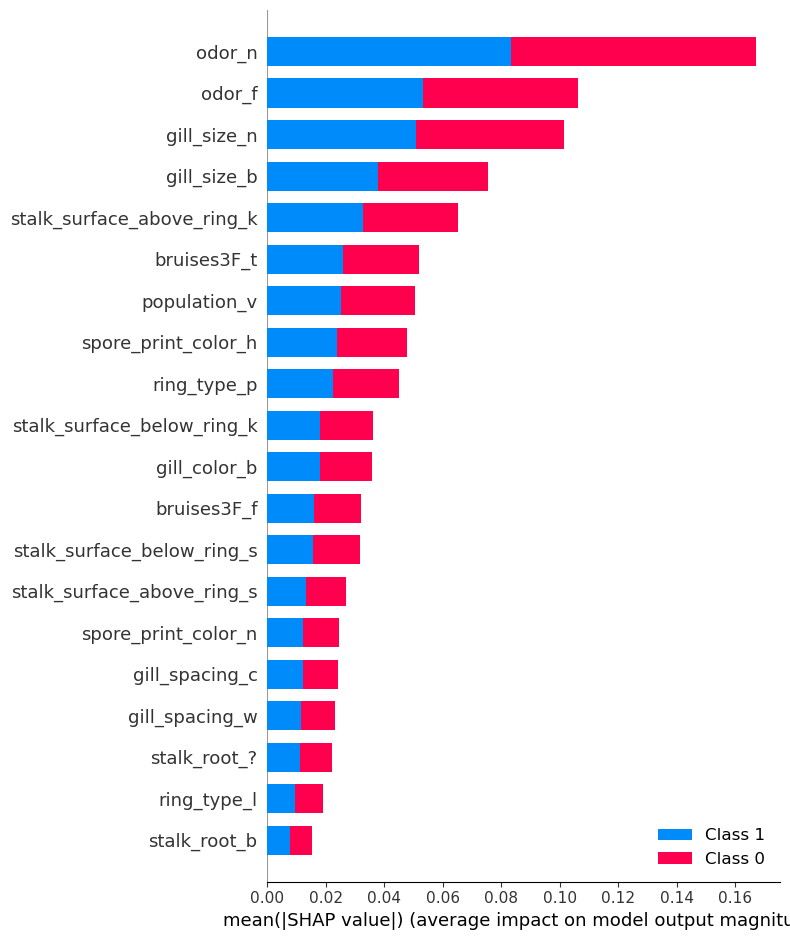

In [12]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=encoded_dataset.feature_names)

# Relation

In [13]:
shap.summary_plot(shap_values, X_train, feature_names=encoded_dataset.feature_names, plot_type="dot")

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!